In [49]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [8, 5]

Populating the interactive namespace from numpy and matplotlib


/Users/jonny/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Problem 1e

In order to perform an integral numerically, we are approximating:

$$y(b) - y(a) = \int_a^b f(x)dx = \int_a^b \frac{dy}{dx}(x)dx$$

Note that we are solving for a velocity increment, or difference which is precisely the
left-hand side of the equation above.

We can approximate its solution simply using the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule):

$$\int_a^b f(x)dx = \frac{\Delta x}{2}\left[f(a) + 2 \sum_{k=1}^{N-1}f(x_k) + f(b)\right]$$

In [2]:
def integrate_trap(f, a, b, args=None, N=100):
    '''
    Uses trapezoidol rule to approximate
    integrate of f(x) from a to b
    '''
    delta_x = (b-a) / float(N)
    xk = np.linspace(a + delta_x, b - delta_x, N-1)
    return delta_x / 2. * (f(a, *args) + 2 * np.sum(f(xk, *args)) + f(b, *args))

Let's try this out with the rocket equation.  The rocket equation was originally derived from conservation of momentum which states that:

$$m_r dU_r = U_e \frac{dm}{m}$$

We know the solution to this is

$$\Delta U_r = U_e \ln{\frac{m_0}{m_f}}$$

Let's compare this with numerical solution.

In [3]:
def f_rocket_equation(m, Ue):
    return Ue / m

Ue = 10.
m0 = 10.
mf = 1.

deltaU_r_analytical = Ue * np.log(m0 / mf)

deltaU_r_numerical = integrate_trap(f_rocket_equation, mf, m0, args=(Ue,))

print 'Analytic results: %.3f m/s' % deltaU_r_analytical
print 'Numerical results: %.3f m/s' % deltaU_r_numerical

Analytic results: 23.026 m/s
Numerical results: 23.033 m/s


Pretty close!

Now let's look at something a bit closer to the problem you are asked to solve.

If we presume that $\beta = \frac{m_f}{m_0}$ how does $\Delta V$ vary with $\beta$?

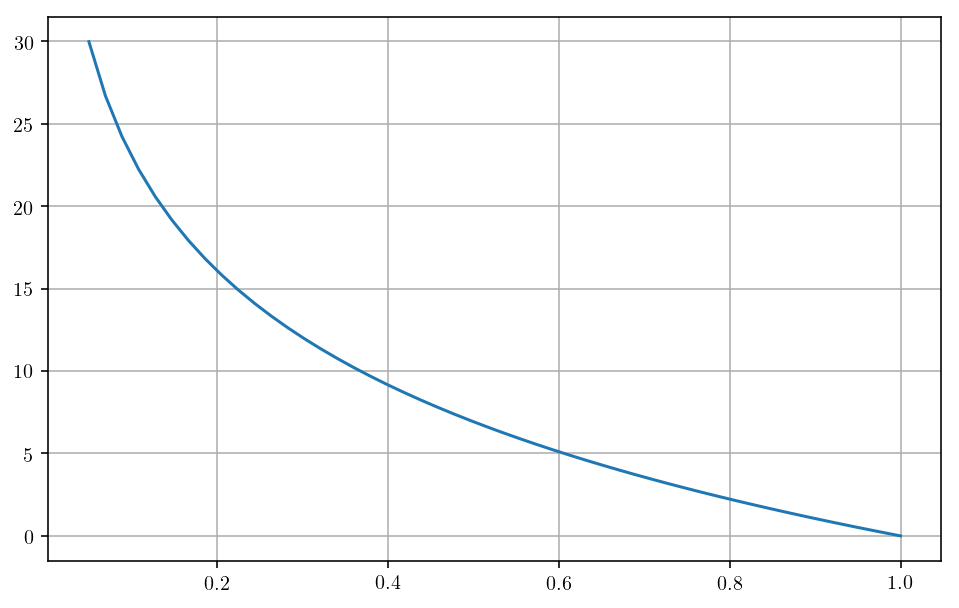

In [50]:
betav = np.linspace(0.05, 1)
deltaU_v = np.zeros_like(betav)

for i, b in enumerate(betav):
    deltaU_v[i] = integrate_trap(f_rocket_equation, b, 1, args=(Ue,))
    
plt.plot(betav, deltaU_v)

## Problem 2

We'll give an example for numerical integration of a 1D trajectory for a case that's similar but not the same as yours.  In this case, we'll assume that there is no water in the rocket and we just pressurize it with air.

In this case we can compute $c^*$, $C_f$ and $C$ as a function of the internal bottle temperature and pressure noting that they are both changing over the blowdown.

A pure gas blow-down is well-approximated by an adiabatic expansion.  Writing the first law, we see that

$$dU = dQ -\delta W \approx 0 -pdV$$

In intrinsic quantities we have

$$du = -p dv$$

Also remember that

$$dh = d\left[u + pv\right] = du + pdv + vdp$$

Given the form of $du$ we can simplify to

$$dh = vdp$$

Now noting that

$$dh = C_p dT$$

and

$$du = C_v dT$$

we see that

$$dT = \frac{-pdv}{C_v} = \frac{vdp}{C_p}$$

or

$$\frac{C_p}{C_v} = \frac{-p/dp}{v/dv}$$

$\frac{C_p}{C_v}$ is $\gamma$ and if we integrate the differential equation above we get

$$Pv^\gamma = \text{const}$$

This is the result from an isentropic process!   So the gas expansion in the bottle is isentropic.

To simulate the blowdown, we will need to track the mass remaining in the bottle.  In general I find density to be more convenient than specific volume so that:

$$m_{air}(t) = V_t \rho_{air}(t)$$

If we know the mass flow out of the bottle we can compute $\rho_{air}$ directly and then use the isentropic relation above but with density rather than specific volume

$$\frac{p}{\rho_{air}^\gamma} = \frac{p(t)}{\rho_{air}^\gamma (t)}$$

Given $p$ and $\rho_{air}$ we can compute temperature using ideal gas law.

If we write conservation of mass

$$\frac{dm_{air}}{dt} = V_t\frac{d\rho_{air}}{dt} = \dot{m}_{air}$$

and note that 

$$\dot{m}_{air}(t) = \frac{p_t(t) A^*}{c^*(t)}$$

We have everything we need to write out an ordinary differential equation for the blowdown.

$$\dot{\rho}_{air} = -\frac{p_t(t) A^*}{V_t c^*(t)}$$

In [7]:
Ru = 8.314  # J / mol - K
def cstar_f(Tt, Mw, gamma):
    return (np.sqrt(Ru/Mw * Tt / gamma) * 
            ((gamma + 1)/2)**((gamma + 1)/2/(gamma-1)))

def Cf_f(Me, P0_Pe, gamma):
    return (((gamma + 1) / 2)**((gamma + 1)/-2/(gamma -1)) / Me /
            np.sqrt(1 + (gamma -1)/2*Me**2) * (gamma * Me**2 + 1 - P0_Pe))

def C_f(Tt, Mw, Pe_Pt, Ae_As, gamma):
    Me = brentq(f, 1.0, 10., args=(gamma, 1./Ae_As))
    return cstar(Tt, Mw, gamma) * Cf(Me, 0.0, gamma)

Alongside this ODE we seek to solve the trajectory in 1D.  Newton's first law states

$$m\ddot{y} = \sum F = F_T - F_D - F_g$$

where $F_T$ is thrust force, $F_D$ is drag force and $F_g$ is gravitational body force.  We can re-write this as

$$\ddot{y} = \frac{T(t) - D(t)}{m(t)} - g_0$$

Thrust is just

$$T = \dot{m}_{air}c^*C_f$$

and drag is

$$D(t) = \frac{1}{2}\rho_{amb}\dot{y}^2$$

where $\rho_{amb}$ is ambient atmospheric air density, NOT the density in the bottle.

Because the trajectory depends on variables related to the first ODE, we must solve these two simulatenously.  There is doable in closed-form so we will re-formulate this as a state-space problem and numerically integrate the state space equation.

$$\begin{gather}
    d\begin{bmatrix}
        \dot{y}\\
        y\\
        \rho_{air}
    \end{bmatrix} =  
    \begin{bmatrix}
        \frac{\dot{m}_{air}c^*C_f - \frac{1}{2}\rho_{amb}\dot{y}^2}{m_{air}}-g0\\
        \dot{y}\\
        -\frac{p_t A^*}{V_t c^*}
    \end{bmatrix}
\end{gather}$$

Assume $C_d = 0.4$ for the analysis or if you're feeling energetic [estimate using this](https://iopscience.iop.org/article/10.1088/0143-0807/30/5/012/pdf).

## Numerical integration

For this analysis, we'll look at two different ODE integration methods - Euler and midpoint.  They are both first-order, single-step explicit methods and are really the simplest of the numerical integration methods.  These are pretty simple schemes and it's good to know how they work but don't spend too much time on it - we'll just provide the functions for you in a general form that will work to solve your problem as well.

In [5]:
def euler_integrate(df, t0, tf, x0, N=100):
    '''
    Given an ODE dx = f(t, x) 
    integrates the ODE from t0 to tf
    over N steps and returns the result.
    '''
    x = np.zeros([N, len(x0)])
    t = np.linspace(t0, tf, N)
    dt = (tf - t0) / float(N)
    x[0, :] = x0
    df0 = df(t0, x0)
    for i in range(1,N):
        x[i, :] = x[i-1, :] + dt * df(t[i], x[i-1, :])
    
    return t, x

def midpt_integrate(df, t0, tf, x0, N=100):
    '''
    Given an ODE dx = f(t, x) 
    integrates the ODE from t0 to tf
    over N steps and returns the result.
    '''
    x = np.zeros([N, len(x0)])
    t = np.linspace(t0, tf, N)
    dt = (tf - t0) / float(N)
    x[0, :] = x0
    df0 = df(t0, x0)
    df_last = df0
    for i in range(1,N):
        x[i, :] = x[i-1, :] + dt * df(t[i] + dt / 2., x[i-1, :] + dt / 2. * df_last)
    
    return t, x

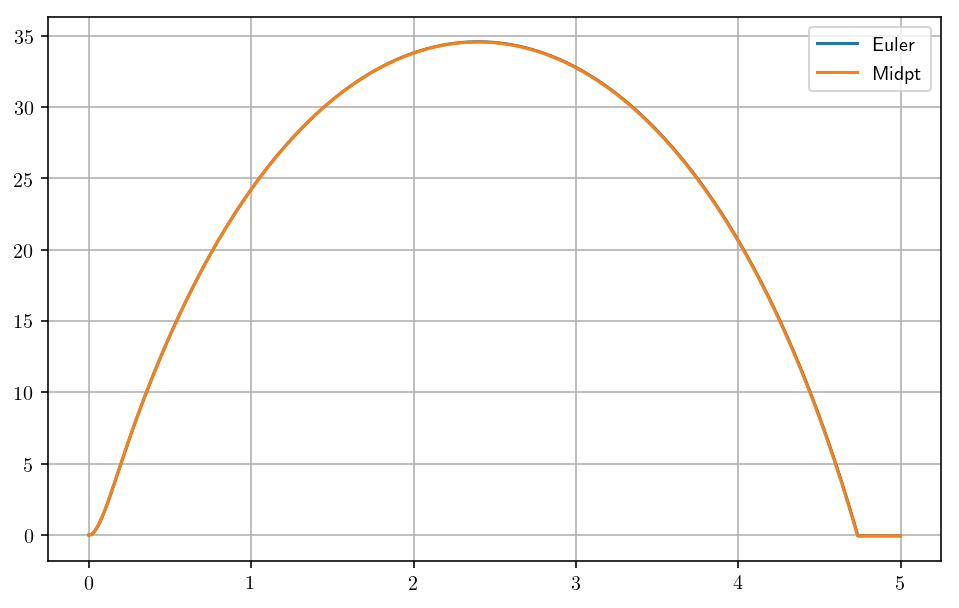

In [90]:
rho_a = 1.2           #kg/m^3
Cd = 0.4
Af = pi * (11e-2)**2 / 4.   # m^2
Ae = pi * (1e-2)**2 / 4.  # m^2
g0 = 9.81             # m/s^2

p0 = 7e5             # Pa
T0 = 298.            # K
Vt = 2. * 1e-3       # m^3
pa = 1e5
ms = 0.1             # kg
gamma = 1.4
Mw = 0.028           # kg/mol
R = Ru / Mw

rho0 = p0 / R / T0

def df(t, x):
    yd = x[0]
    y = x[1]
    rho = x[2]
    dx = np.zeros([3])
    
    pt = p0 * (rho / rho0)**gamma
    pe = pt * ((1. + (gamma - 1) / 2.)**(-gamma / (gamma - 1)))
    Tt = pt / rho / R
    m = rho * Vt + ms
    
    if pe < pa:
        # Nozzle is not chocked
        Me2 = np.maximum(((pa / pt)**((gamma - 1) / -gamma) - 1.) * 2 / (gamma - 1), 0)
        pe = pt * ((1. + (gamma - 1) / 2. * Me2)**(-gamma / (gamma - 1)))
        Te = Tt * (1 + (gamma - 1) / 2 * Me2)
        rhoe = pa / R / Te
        C =  np.sqrt(Me2 * gamma * R * Te)
        mdot = rhoe * Ae * C
    else:
        # We're chocked
        cstar = cstar_f(Tt, Mw, gamma)
        Cf = Cf_f(1.0, pa/pe, gamma)
        C = cstar * Cf
        mdot = pt * Ae / cstar
    
    # Check if we've hit the ground
    if y < 0.:
        dx[0] = 0.
        dx[1] = 0.
        dx[2] = 0.
    # Check if we've expanded all the way to atmospheric pressure
    elif pt <= pa:
        dx[0] = ((- 0.5 * Cd * Af * rho_a * yd**2) / m - g0)
        dx[1] = yd
        dx[2] = 0.
    # We're still thrusting!
    else:
        dx[0] = ((mdot * C - 0.5 * Cd * Af * rho_a * yd**2) / m - g0)
        dx[1] = yd
        dx[2] = -mdot / Vt
    
    return dx

t, x = euler_integrate(df, 0, 5, [0, 0, rho0], N=2000)
t1, x1 = midpt_integrate(df, 0, 5, [0, 0, rho0], N=2000)
plt.plot(t, x[:,1], label='Euler')
plt.plot(t1, x1[:,1], label='Midpt')
plt.legend()

Text(0,0.5,'$d_t (cm)$')

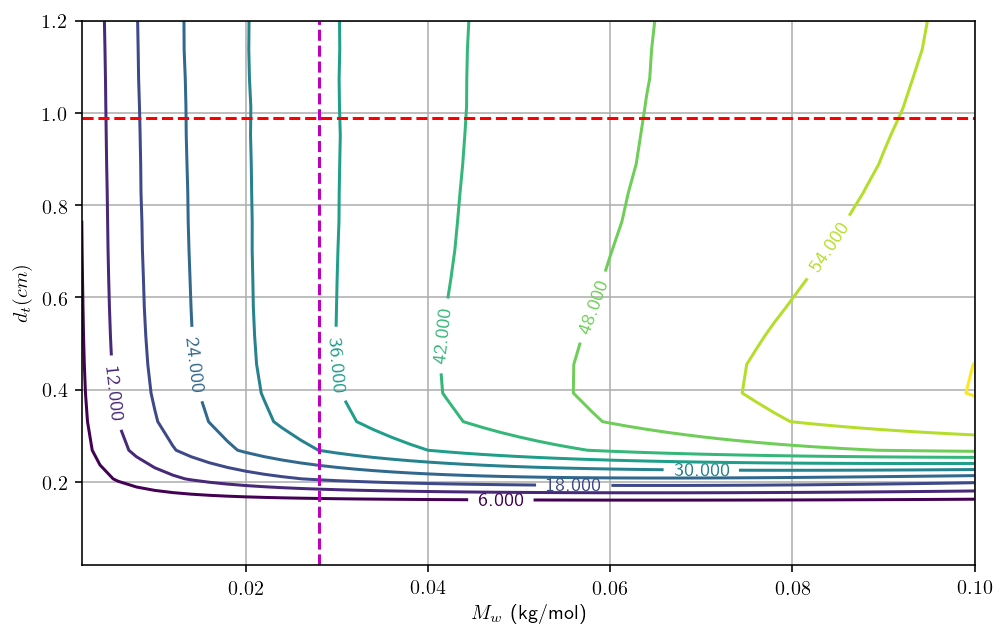

In [97]:
dt_v = np.linspace(0.02e-2, 1.2e-2, 20)
Mwv = np.linspace(0.002, .1)

altv = np.zeros([len(dt_v), len(Mwv)])

for i, d in enumerate(dt_v):
    for j, Mw in enumerate(Mwv):
        R = Ru / Mw
        rho0 = p0 / R / T0
        Ae = pi*d**2 / 4.
        t1, x1 = midpt_integrate(df, 0, 10, [0, 0, rho0], N=2000)
        altv[i, j] = np.max(x1[:, 1])
        
fig, ax = plt.subplots()
CS = ax.contour(Mwv, dt_v*1e2, altv, 10)
ax.clabel(CS, inline=1, fontsize=10)
plt.axhline(0.39 * 2.54, c='r', ls='--')
plt.axvline(0.028, c='m', ls='--')
plt.xlabel(r'$M_w$ (kg/mol)')
plt.ylabel(r'$d_t (cm)$')

Text(0,0.5,'$d_t (cm)$')

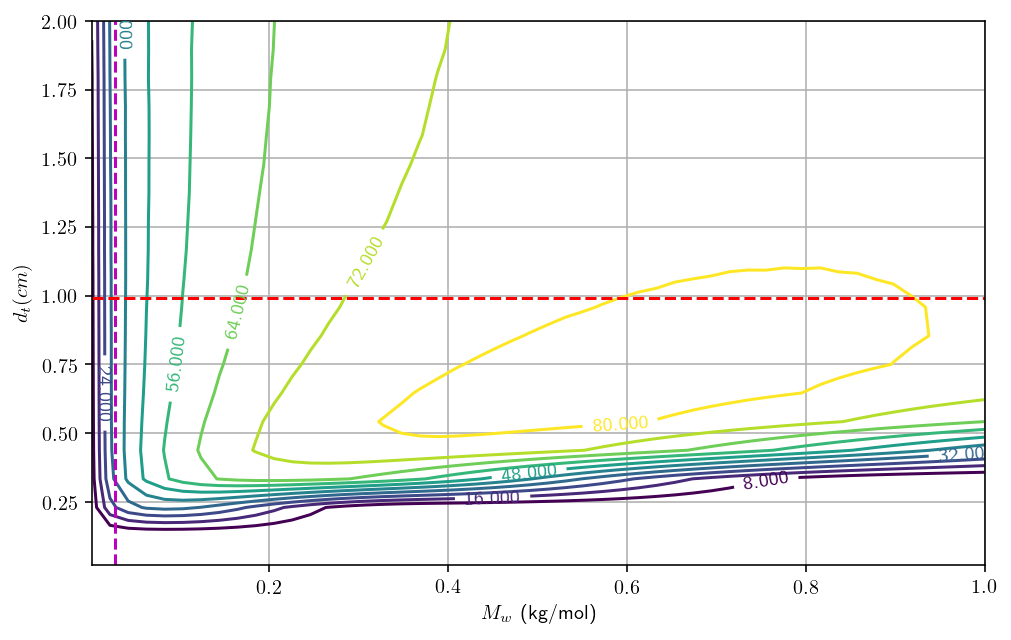

In [98]:
dt_v = np.linspace(0.02e-2, 2e-2, 20)
Mwv = np.linspace(0.002, 1)

altv = np.zeros([len(dt_v), len(Mwv)])

for i, d in enumerate(dt_v):
    for j, Mw in enumerate(Mwv):
        R = Ru / Mw
        rho0 = p0 / R / T0
        Ae = pi*d**2 / 4.
        t1, x1 = midpt_integrate(df, 0, 10, [0, 0, rho0], N=2000)
        altv[i, j] = np.max(x1[:, 1])
        
fig, ax = plt.subplots()
CS = ax.contour(Mwv, dt_v*1e2, altv, 10)
ax.clabel(CS, inline=1, fontsize=10)
plt.axhline(0.39 * 2.54, c='r', ls='--')
plt.axvline(0.028, c='m', ls='--')
plt.xlabel(r'$M_w$ (kg/mol)')
plt.ylabel(r'$d_t (cm)$')